<a href="https://colab.research.google.com/github/hugo-ta/Regulatory-Inspections/blob/main/FDA_Observations_Cluster_Analysis_KPrototypes_UMAP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Applying Unsupervised Learning to FDA Inspections and Citations**

#####FDA is a US agency responsible for assuring the safety and quality of foods, medicines, and cosmetics entering the US. One of its robust set of tools is inspection of domestic and foreign manufacturers and market authority holders. This analysis focused on biologics, devices, and drugs. 

Excluding few cases, FDA classifies inspections into one of the following:

*   No Action Indicated (NAI)
*   Voluntary Action Indicated (VAI)
*   Official Action Indicated (OAI)

Inspections are classified NAI if no objectionable conditions (i.e. observations) are found. Inspections are classified OAI if serious violations to rules and regulations are found. OAI inspections often result in enforcement actions such as warning letters, consent decrees and import alerts to stop manufacturing within US or prevent shipment of products into US. All other inspections are classified VAI.

In this project, the goal is to characterize inspections classified OAI, VAI or NAI in Human Drugs, Biologics, and Medical Devices.



# **1. Import Libraries**

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
import numpy as np
import pandas as pd

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MaxAbsScaler, PowerTransformer
from sklearn.compose import make_column_selector, make_column_transformer, ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, cohen_kappa_score, precision_score, recall_score, f1_score, accuracy_score, log_loss
from yellowbrick.model_selection import ValidationCurve
from yellowbrick.target import ClassBalance

!pip install umap-learn
import umap
from umap import umap_
!pip install kmodes
from kmodes.kprototypes import KPrototypes

import xgboost
from xgboost import XGBClassifier
import lightgbm as lgbm
from lightgbm import LGBMClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

import warnings
!pip install ipython-autotime
%load_ext autotime

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


time: 1.56 ms


#**2. Load & Merge Data Sources**

#####FDA publishes inspectional data from 2008 to present. Published data sets do not represent all inspections as the FDA neither publishes Pre-Approval Inspections (PAI) nor includes inspection reports submitted in paper.

In [2]:
# Load data sources
url1 = 'https://www.fda.gov/media/79333/download' # FDA inspectional classification
df1 = pd.read_excel(url1)
url2 = 'https://www.fda.gov/media/107480/download' # FDA inspectional observations
df2 = pd.read_excel(url2)

time: 40 s


In [3]:
# Merge inspectional classification and inspectional citations data sources

# Outer join to include inspections classified NAI as inspections in right dataframe are never classified NAI
df = pd.merge(df1, df2, how='outer', 
              left_on=['Legal Name', 'Inspection End Date'], 
              right_on=['Firm Name', 'Inspection End Date']
              )

df = df[['Firm Name', 'Country/Area_y', 'Program Area', 'Inspection End Date', 
         'Classification', 'CFR/Act Number', 'Short Description', 
         'Long Description']]

df = df.rename(columns={'Country/Area_y':'Country'})

df.drop_duplicates(inplace=True)

time: 1.04 s


In [4]:
# Dataframe lists citations 
df.tail(3)

,Firm Name,Country,Program Area,Inspection End Date,Classification,CFR/Act Number,Short Description,Long Description
481426,"US Pharmatech, Inc.",United States,Foods,2020-09-28,NaN,21 CFR 111.205(b)(2),"Master manufacturing record - controls, proced...",Your master manufacturing record did not estab...
481427,"US Pharmatech, Inc.",United States,Foods,2020-09-28,NaN,21 CFR 111.70(b)(2),"Specifications-component purity, strength, com...",You did not establish component specifications...
481428,"US Pharmatech, Inc.",United States,Foods,2020-09-28,NaN,21 CFR 111.70(b)(3),Specifications - contamination limits,You did not establish limits for contamination...


time: 32.1 ms


#**3. Data Processing**

###**3.1. Data Cleaning**

In [5]:
# Check for missing values

((df
  .isna()
  .mean()
  *100)
  .pipe(lambda ser : ser[ser > 0])
)

# Only Inspection End Date column has no missing values

Firm Name            3.029677
Country              3.029677
Program Area         3.029677
Classification       0.599281
CFR/Act Number       3.096986
Short Description    3.029677
Long Description     3.030825
dtype: float64

time: 96.8 ms


In [6]:
# Citations count by classification
df['Classification'].value_counts(dropna=False)

VAI    178497
OAI     43158
NAI     38258
NaN      1567
Name: Classification, dtype: int64

time: 30.8 ms


In [7]:
# Citations count by program area
df[df['Classification'].isna()]['Program Area'].value_counts(dropna=False)

Foods                               900
Devices                             248
Drugs                               189
Veterinary Medicine                  67
Biologics                            52
Human Tissue for Transplantation     46
Parts 1240 and 1250                  37
Bioresearch Monitoring               21
Radiologic Health                     5
Part 11 Compliance                    2
Name: Program Area, dtype: int64

time: 21.1 ms


In [8]:
# Countries ranked by citation count in descending order
(df['Country'].value_counts().to_frame().reset_index()
).rename(columns={'Country':'Count','index':'Country'})['Country'].head(10)

0              United States
1                      India
2                     Canada
3                    Germany
4                      Italy
5    Korea (the Republic of)
6                      Japan
7                      China
8             United Kingdom
9                      Spain
Name: Country, dtype: object

time: 38 ms


###**3.2. Feature Engineering**

Since the merged dataframe is indexed by citations and this project aims to characterize inspection classification, I am grouping all the observations by inspection and counting the number of citations. I am also imputing the data, creating a regional feature, and filtering the inspections to those of interest:


*   Human Drugs
*   Biologics
*   Devices



In [9]:
# Dictionary to group countries into regions

dict_region = {'NA':['United States','Canada'],
              'APAC':['Thailand','Taiwan','Japan','China','India','Fiji','Philippines',
                      'Korea (the Republic of)','Singapore','Malaysia','Vietnam',
                      'Indonesia','Australia','Hong Kong SAR','Bangladesh','Macao',
                      'Maldives','French Polynesia','New Zealand','Sri Lanka',
                      'Western Samoa'],
              'EMEA':['Germany','Sweden','United Kingdom','Netherlands','Hungary',
                      'Russia','Czech Republic','Ireland','France','Spain','Switzerland',
                      'Italy', 'Portugal','Belgium','Denmark','South Africa','Slovakia',
                      'Israel','Austria','Greece','Norway','Poland','Romania','Croatia',
                      'Saudi Arabia','Egypt','Jordan','Ghana','Oman','Finland','Bulgaria',
                      'Serbia','Turkey','Slovenia','Tunisia','Morocco','Tonga','Belarus',
                      'Estonia','Madagascar','Macedonia','Malawi','Ukraine','Malta',
                      'Lithuania','Monaco','Iceland','Senegal','Latvia','Cyprus',
                      'Liechtenstein','Bosnia-Hercegovina','Armenia',
                      'United Arab Emirates','Georgia','Cape Verde','Faroe Islands',
                      'Ivory Coast','Mauritius'],
              'LATAM':['Ecuador','Peru','Mexico','Dominican Republic (the)',
                      'Guatemala','Columbia','Brazil','Chile','Costa Rica',
                      'Nicaragua','Panama','Venezuela','Barbados','Argentina',
                      'Paraguay','Surinam','El Salvador','Trinidad & Tobago',
                      'St. Vincent & The Grenadines','Bolivia','Bahamas','Jamaica',
                      'Uruguay','Belize','Grenada','Guyana','Colombia']
              }

time: 11.8 ms


In [10]:
def count_citation(df):
  """
  Function counts citations for each inspection and imputes data
  Parameter
  ---------
    df: dataframe
  Returns
  -------
    dataframe
  """
  df.loc[(df['Classification'] == 'OAI') | (df['Classification'] == 'VAI'),'Citations'] = 1
  df.loc[df['Classification'] == 'NAI','Citations'] = 0
  df['Program Area'].replace({'Foods':'Other',
                       'Veterinary Medicine':'Other',
                       'Bioresearch Monitoring':'Other',
                       'Human Tissue for Transplantation': 'Other',
                       'Parts 1240 and 1250': 'Other',
                       'Radiologic Health': 'Other',
                       'Part 11 Compliance': 'Other'},
                       inplace=True
                       )
  def limit_domestic(val):
    if val in {'United States'}:
      return 'Domestic'
    return 'Foreign'
  df['Domestic'] = df['Country'].apply(limit_domestic)
  df['Region'] = df['Country']
  for k in dict_region.keys():
    df.loc[df['Country'].isin(dict_region[k]), 'Region'] = k
  df = df.groupby(['Firm Name', 
                    'Country',
                    'Region', 
                    'Domestic',
                    'Inspection End Date', 
                    'Program Area',
                    'Classification'])['Citations'].sum().reset_index()
  df = df[df['Program Area'] != 'Other']
  df.sort_values(by=['Inspection End Date'], inplace=True, ascending=True)
  df = df.reset_index().drop('index', axis=1)
  df = df.astype({'Citations':int})
  return df

time: 24 ms


In [11]:
count_citation(df)

,Firm Name,Country,Region,Domestic,Inspection End Date,Program Area,Classification,Citations
0,Pekana Naturheilmittel GmbH,Germany,EMEA,Foreign,2008-10-02,Drugs,VAI,3
1,"EyeKon Medical, Inc.",United States,NA,Domestic,2008-10-03,Devices,NAI,0
2,"Translite, LLC",United States,NA,Domestic,2008-10-03,Devices,VAI,3
3,"EyeKon Medical, Inc.",United States,NA,Domestic,2008-10-03,Devices,OAI,13
4,"Translite, LLC",United States,NA,Domestic,2008-10-03,Devices,NAI,0
...,...,...,...,...,...,...,...,...
23052,"BPC Plasma, Inc.",United States,NA,Domestic,2020-10-21,Biologics,NAI,0
23053,"Viant AS&O Holdings, LLC",United States,NA,Domestic,2020-10-23,Devices,VAI,2
23054,"Viant AS&O Holdings, LLC",United States,NA,Domestic,2020-10-23,Devices,NAI,0
23055,Frostime Llc,United States,NA,Domestic,2020-10-28,Devices,VAI,1


time: 546 ms


In [12]:
# Update dict if there are regions other than NA, EMEA, APAC, and LATAM
count_citation(df)['Region'].value_counts(dropna=False)

NA       19784
EMEA      1824
APAC      1341
LATAM      108
Name: Region, dtype: int64

time: 455 ms


#**4. Exploratory Data Analysis**

In [13]:
def prep_viz(df, start_date=False, encode_class=False):
  """
  Function prepares dataframe for data visualizations by filtering 
  date and encoding observation classification as needed
  Parameters
  ----------
    df: dataframe from count_citation()
    start_date: {string} date format YYYY-MM-DD
    encode_class: {bool} True or False
  Returns
  -------
    dataframe
  """
  if start_date:
    df = df[df['Inspection End Date'] >= start_date]
  if encode_class:
    df['Classification'] = df['Classification'].replace({'NAI':0,'VAI':1,'OAI':2})
    df = df.astype({'Classification':int})
  df.sort_values(by=['Inspection End Date'], inplace=True, ascending=True)
  df = df.reset_index().drop('index', axis=1)
  df['Year'] = df['Inspection End Date'].dt.year
  return df

prep_viz(count_citation(df), start_date='2015-01-01', encode_class=True).head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Firm Name,Country,Region,Domestic,Inspection End Date,Program Area,Classification,Citations,Year
0,ITxM Clinical Services,United States,NA,Domestic,2015-01-02,Biologics,1,3,2015
1,Bard Peripheral Vascular Inc,United States,NA,Domestic,2015-01-05,Devices,2,3,2015
2,"Brewer Company, LLC",United States,NA,Domestic,2015-01-05,Devices,1,6,2015
3,Arcet Equipment Company dba Arc3 Gases North,United States,NA,Domestic,2015-01-05,Drugs,1,1,2015
4,"Pharmaceutica North America, Inc.",United States,NA,Domestic,2015-01-06,Drugs,1,5,2015


time: 495 ms


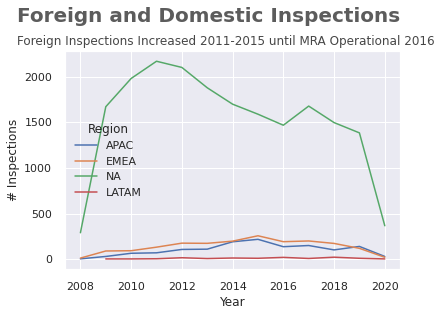

time: 823 ms


In [14]:
# Foreign and Domestic Inspections

data = prep_viz(count_citation(df), start_date='2008-01-01')
data = data.groupby(['Year', 'Region']).count().reset_index()

sns.set(style='darkgrid')
g = sns.lineplot(x='Year',
             y='Firm Name',
             hue='Region',
             data=data)
g.text(x=2005.5, 
       y=2600, 
       s='Foreign and Domestic Inspections',
       fontsize=20, 
       weight='bold', 
       alpha=.75)
g.text(x=2005.5, 
       y=2350,
       s='Foreign Inspections Increased 2011-2015 until MRA Operational 2016',
       fontsize=12, 
       alpha=.85)
plt.xlabel('Year')
plt.ylabel('# Inspections')
plt.show()

# Inspections remain high in NA, but there is decreasing trend as FDA focuses on foreign inspections

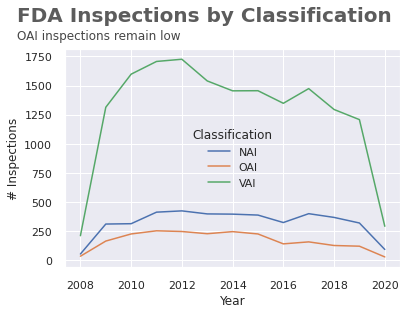

time: 810 ms


In [15]:
# FDA Inspections by Classification

data = prep_viz(count_citation(df))
data = data.groupby(['Year', 'Classification']).count().reset_index()

sns.set(style='darkgrid')
g = sns.lineplot(x='Year',
             y='Firm Name',
             hue='Classification',
             data=data)
g.text(x=2005.5, 
       y=2050, 
       s='FDA Inspections by Classification',
       fontsize=20, 
       weight='bold', 
       alpha=.75)
g.text(x=2005.5, 
       y=1900,
       s='OAI inspections remain low',
       fontsize=12, 
       alpha=.85)
plt.xlabel('Year')
plt.ylabel('# Inspections')
plt.show()

# FDA classifies inspections as VAI more often than NAI, and classifies inspections NAI more often than OAI

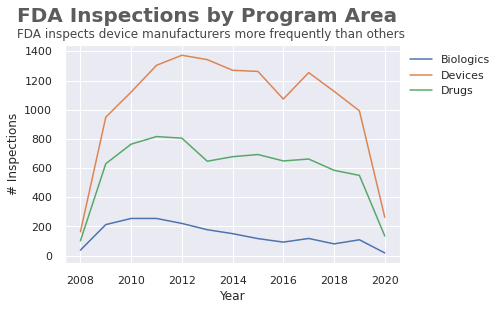

time: 805 ms


In [16]:
# FDA Inspections by Program Area

data = prep_viz(count_citation(df))
data = data.groupby(['Year', 'Program Area']).count().reset_index()

sns.set(style='darkgrid')
g = sns.lineplot(x='Year',
             y='Firm Name',
             hue='Program Area',
             data=data)
g.text(x=2005.5, 
       y=1600, 
       s='FDA Inspections by Program Area',
       fontsize=20, 
       weight='bold', 
       alpha=.75)
g.text(x=2005.5, 
       y=1490,
       s='FDA inspects device manufacturers more frequently than others',
       fontsize=12, 
       alpha=.85)
g.legend(bbox_to_anchor=(1,1))
plt.xlabel('Year')
plt.ylabel('# Inspections')
plt.show()

# FDA inspects device manufacturers more often than drug manufacturers

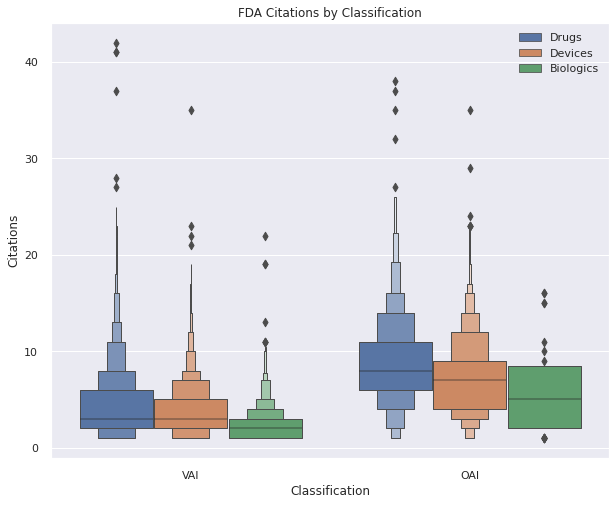

time: 797 ms


In [17]:
# Boxenplot of FDA Citations by Classification

data = prep_viz(count_citation(df))
data = data[~(data['Classification'] == 'NAI')] # NAI classification = 0 citations

f, ax = plt.subplots(figsize=(10,8))
g = sns.boxenplot(x='Classification', 
              y='Citations', 
              hue='Program Area', 
              data=data)
g.legend(bbox_to_anchor=(1,1))
plt.title('FDA Citations by Classification')
plt.show()

# Inspections classified OAI have higher median citation counts than inspections classified VAI
# However, there are notable outliers in VAI dataset where there are two inspections with more citations than any other inspection in the OAI dataset

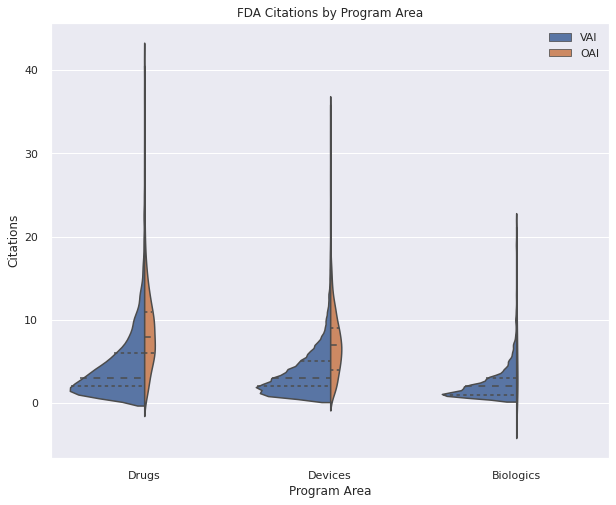

time: 765 ms


In [18]:
# Violinplot of FDA Citations by Program Area

data = prep_viz(count_citation(df))
data = data[~(data['Classification'] == 'NAI')] # NAI classification = 0 citations

f, ax = plt.subplots(figsize=(10,8))
g = sns.violinplot(x='Program Area', y='Citations', hue='Classification',
                    data=data, palette='deep', split=True,
                    scale='count', inner='quartile')
g.legend(bbox_to_anchor=(1,1))
plt.title('FDA Citations by Program Area')
plt.show()

# In all programs, citations in VAI dataset is skewed left (which consumers want) while citations in OAI are more normal but more variance

#**5. Cluster Analysis**

In this project, I use Uniform Manifold Approximation and Projection (UMAP) to visually select K, and KPrototypes to cluster the inspections data containing mixed type data.

Inspiration for this cluster analysis comes from [Antons Ruberts](https://github.com/AntonsRuberts)

###**5.1. UMAP**

UMAP visualizes and compares clusters by embedding high-dimensional data into two dimensions similar to PCA and t-SNE. Here is the procedure:

1.   Split features into numeric and categorical
2.   Apply PowerTransformer() to numeric features and one-hot encoding to categorical features
3.   Embed features separately using different metrics: 'l2' for numeric and 'dice' for categorical
4.   Combine embeddings as suggested [here](https://github.com/lmcinnes/umap/issues/58#issuecomment-419682509)

I use a non-linear manifold learner like UMAP over a liner projection like PCA because non-linear learners prioritize pairwise distance between neighbors while linear learners assigns equal weights. Moreover, I use UMAP over other non-linear manifolds like tSNE because UMAP components preserve both local structure (data points within clusters) and global structure (data points between clusters) more than tSNE.

In [19]:
umap_data = count_citation(df).drop(columns=['Inspection End Date','Firm Name'])

time: 439 ms


In [20]:
# Preprocess numeric features
num_cols = umap_data.select_dtypes(exclude='object')
for col in num_cols.columns:
  pt = PowerTransformer() # Transforms datapoints for Gaussian-like distribution
  num_cols.loc[:, col] = pt.fit_transform(np.array(num_cols[col]).reshape(-1, 1))
    
# Preprocess categorical features
cat_cols = umap_data.select_dtypes(include='object')
cat_cols = pd.get_dummies(cat_cols)

time: 88.6 ms


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1734: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


In [21]:
# Percentage of categorical columns is used as weight parameter
categorical_weight = len(umap_data.select_dtypes(include='object').columns) / umap_data.shape[1]

# Instantiate UMAP objects and fit to data
umap_num = umap_.UMAP(random_state=42, metric='l2')
mapper1 = umap_num.fit(num_cols)
umap_cat = umap_.UMAP(random_state=42, metric='dice')
mapper2 = umap_cat.fit(cat_cols)

/usr/local/lib/python3.6/dist-packages/umap/umap_.py:1530: UserWarning: gradient function is not yet implemented for dice distance metric; inverse_transform will be unavailable
  "inverse_transform will be unavailable".format(self.metric)


time: 2min 28s


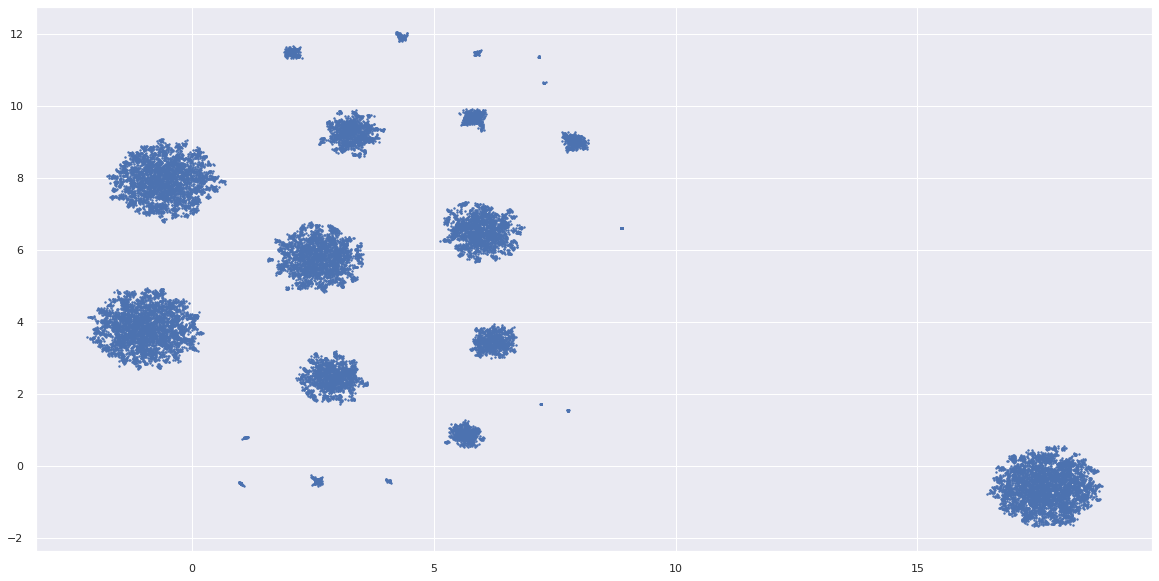

time: 1min 10s


In [22]:
# Combine the numeric and categorical embeddings
intersection = umap.umap_.general_simplicial_set_intersection(mapper1.graph_, 
                                                              mapper2.graph_, 
                                                              weight=categorical_weight)
intersection = umap.umap_.reset_local_connectivity(intersection)
embedding = umap.umap_.simplicial_set_embedding(mapper1._raw_data, intersection, 
                                                mapper1.n_components, 
                                                mapper1._initial_alpha, 
                                                mapper1._a, mapper1._b, 
                                                mapper1.repulsion_strength, 
                                                mapper1.negative_sample_rate, 
                                                200, 'random', np.random, 
                                                mapper1.metric, mapper1._metric_kwds, False)

# Plot UMAP embeddings
plt.figure(figsize=(20, 10))
plt.scatter(*embedding.T, s=2, cmap='Spectral', alpha=1.0)
plt.show()

###**5.2. K-Prototype Clustering**

I use K-Prototypes, not K-Modes or K-Means, to accommodate mixed type data (numeric and categorical). K-Prototypes implementation (KPrototypes) via KModes can accept object values directly without the need for encoding (one-hot, label, etc). However, it is important to explicitly identify categorical columns in the parameter.

In [23]:
def feature_index(df, select_dtype='int'):
  """
  Function returns list of indices by dataframe column dtype
  Parameters
  ----------
    df = dataframe
    select_dtype = {string} 'int' returns indices for numeric columns; 
      'object' returns indices for categorical columns; 
      default is 'int'
  Returns
  -------
    feature_index: {list} list of indices
  """
  df_new = (df.dtypes.to_frame().reset_index()
           ).rename(columns={'index':'feature', 0:'dtype'})
  if select_dtype == 'int':
    feature_index = list(df_new[df_new['dtype'] == 'int'].index)
  if select_dtype == 'object':
    feature_index = list(df_new[df_new['dtype'] == 'object'].index)
  return feature_index

time: 8.44 ms


In [24]:
# Drop date and firm name due to high cardinality
df_kproto = count_citation(df).drop(columns=['Inspection End Date','Firm Name'])

# Select optimal K from UMAP scatterplot
K_umap = 7

# Preprocess numeric features
for col in df_kproto.select_dtypes(exclude='object').columns:
  pt = PowerTransformer()
  df_kproto[col] =  pt.fit_transform(np.array(df_kproto[col]).reshape(-1, 1))

# K-Prototype clustering
kproto = KPrototypes(random_state=0, n_clusters=K_umap, init='Cao', n_jobs=-1)
clusters = kproto.fit_predict(df_kproto, categorical=feature_index(df_kproto, select_dtype='object'))

# Assign cluster label to dataframes
df_kproto['Cluster'] = kproto.labels_

time: 2min 8s


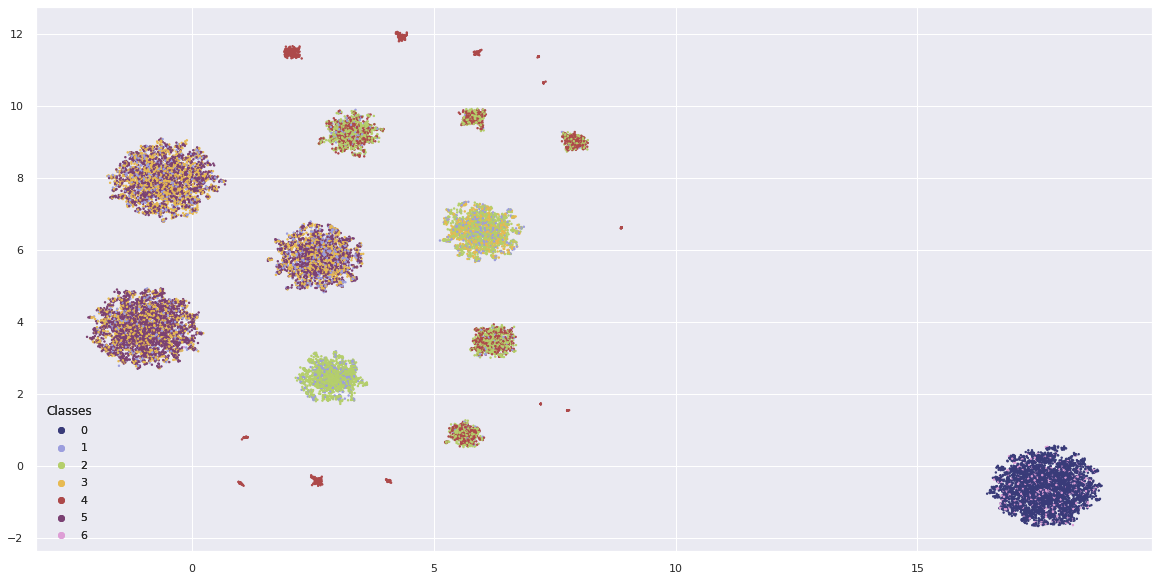

time: 784 ms


In [25]:
fig, ax = plt.subplots()
fig.set_size_inches((20, 10))
scatter = ax.scatter(embedding[:, 0], embedding[:, 1], s=2, 
                     c=clusters, cmap='tab20b', alpha=1.0)
legend = ax.legend(*scatter.legend_elements(num=K_umap),
                    loc='lower left', title='Classes')
ax.add_artist(legend)
plt.show()

###**5.3. Explore Clusters**

After assigning inspections to clusters, I visually explore characteristics of each cluster

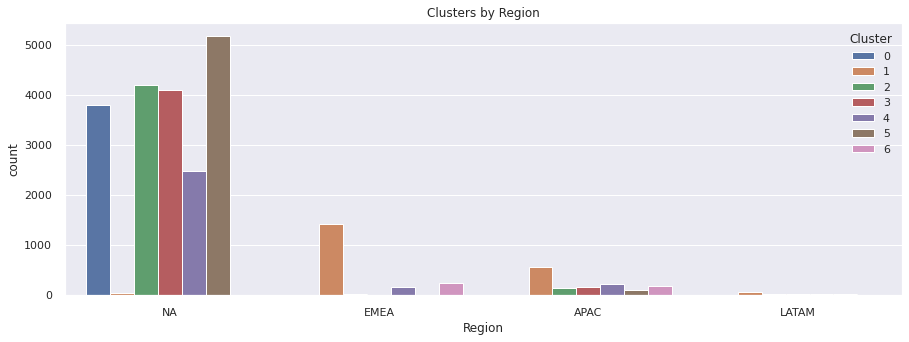

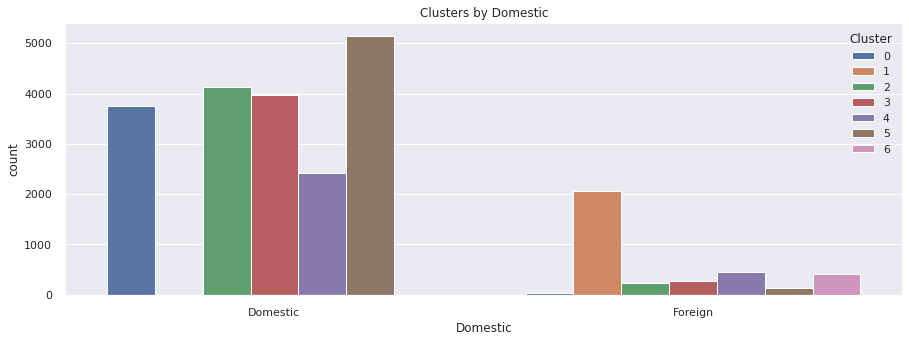

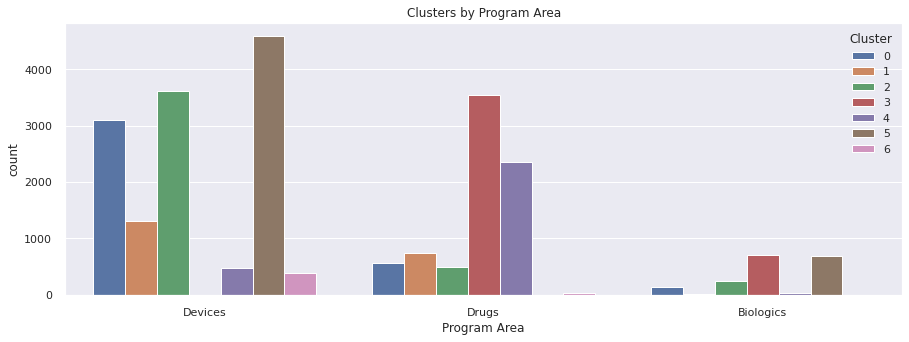

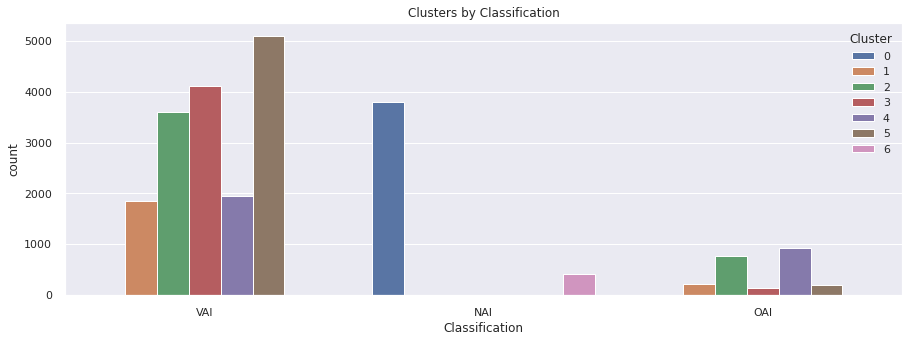

time: 1.23 s


In [26]:
def cluster_summary_plot(df, feature):
  """
  Function plots inspection count ordered by 'feature' and colored by cluster
  Parameters
  ----------
    df = dataframe
    feature = {string} feature name
  Returns
  -------
    seaborn countplot
  """
  plt.subplots(figsize = (15,5))
  sns.countplot(x=df[feature], 
                order=df[feature].value_counts().index, 
                hue=df['Cluster'])
  plt.title(f'Clusters by {feature}')
  plt.show()

# Loop through Region, Domestic, Program Area, and Classification features to countplot
for col in [col for col in list(df_kproto.columns) if col not in ['Cluster', 'Citations', 'Country']]:
  cluster_summary_plot(df_kproto, feature=col)

In [27]:
# Heatmap of features and clusters
(pd.get_dummies(df_kproto)
   .groupby('Cluster')
   .mean()
   .T
   .style.background_gradient(cmap='viridis', axis=1)
)

Cluster,0,1,2,3,4,5,6
Citations,-1.537166,0.210738,0.865509,-0.102984,1.492299,-0.296627,-1.528935
Country_Argentina,0.000000,0.001943,0.000000,0.000000,0.000349,0.000000,0.000000
Country_Australia,0.000000,0.009713,0.001832,0.001645,0.003489,0.000567,0.016548
Country_Austria,0.000000,0.011170,0.000000,0.000000,0.002094,0.000000,0.009456
Country_Bahamas,0.000000,0.000000,0.000000,0.000000,0.000349,0.000000,0.000000
Country_Barbados,0.000000,0.000486,0.000000,0.000000,0.000000,0.000000,0.000000
Country_Belgium,0.000000,0.015542,0.000229,0.000000,0.001396,0.000000,0.009456
Country_Brazil,0.000000,0.003400,0.000229,0.000470,0.000698,0.000000,0.004728
Country_Canada,0.009218,0.020398,0.013281,0.027726,0.018842,0.007185,0.000000
Country_China,0.000000,0.075765,0.012365,0.002820,0.005932,0.008697,0.193853


time: 218 ms


From the visuals, I can see the following:

*   Inspections classified OAI are often clustered with inspections for devices or drugs, in North American or APAC countries, and end with high count of citations
*   Inspections classified NAI are often clustered with inspections for devices; in US, China, and Germany; and end with lowest count of citations (none)
*   Inspections classified VAI vary but are often clustered with inspections for drugs or devices or biologics; in US, Canada, and India; and end with high count of citations (not as high as those classified OAI)
*   Inspections ending with highest count of citations are often clustered with inspections for drugs and, to lesser extent, devices, in North America, and classified VAI
*   Inspections for biologics are often clustered with inspections in North America, classified VAI, and end with low count of citations







###**5.4. Evaluate Clusters with Classification Model**

Lastly, I build a multiclass classification model to predict clusters as a means of evaluating their quality. I evaluate models using several metrics (e.g. ROC AUC, Precision, Recall, F1, Cohen Kappa), and specifically aim for high ROC AUC greater than or equal to 0.85 and a Cohen Kappa metric larger than or equal to 0.80 for excellent inter-rater agreement. If the best performing classification model predicts K-Prototype clusters well, I can conclude that the clusters constructed through K-Prototype are distinguishable.

#####**5.4.1. Construct Model Pipeline**

In [28]:
# Final feature selection for multiclass classification model
final_data = count_citation(df).drop(columns=['Inspection End Date','Firm Name'])
final_data['Cluster'] = kproto.labels_
X = final_data[['Country','Program Area','Classification']]
y = final_data[['Cluster']]

# Split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=0, stratify=y)

time: 580 ms


In [29]:
def get_features(x):
  # Categorical features
  col_cat = [key for key in dict(x.dtypes)
                 if dict(x.dtypes)[key] in ['object', 'bool']]
  # Numeric features
  col_num = [key for key in dict(x.dtypes)
                 if dict(x.dtypes)[key] in ['float64','float32','int32','int64']]
  return col_cat, col_num

time: 4.04 ms


In [30]:
# Split into two lists of categorical and numeric features
col_cat, col_num = get_features(X_train)

# Construct preprocessing pipeline for multiclass classification
pipe_cat = OneHotEncoder(handle_unknown='ignore')
pipe_num = StandardScaler()
preprocessor = make_column_transformer((pipe_cat, col_cat), (pipe_num, col_num))

time: 8.23 ms


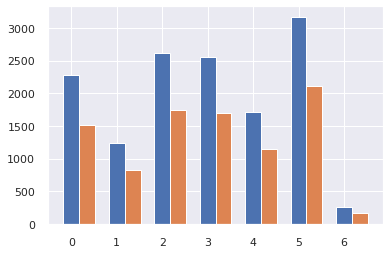

time: 263 ms


In [31]:
# Inspect class imbalance
visualizer = ClassBalance()
visualizer.fit(y_train.values.ravel(), y_test.values.ravel())
plt.show()

#####**5.4.2. Build and Evaluate Models**

In [32]:
def print_predictions(model, X_train=X_train, y_train=y_train, X_test=X_test, 
                      y_test=y_test, multi_class='ovr', average='weighted'):
  """
  Function prints evaluation metrics for fitted sklearn models
  Parameters
  ----------
    model: {sklearn object} fitted model
    X_train, y_train, X_test, y_test: {array-like, sparse matrix} training and testing data
    multi_class: parameter passed to evaluation metrics
    average: parameter passed to evaluation metrics
  Outputs
  -------
    Metrics
  """
  print('training auc: '+str(roc_auc_score(y_train, model.predict_proba(X_train), multi_class=multi_class)))
  print('testing auc:  '+str(roc_auc_score(y_test, model.predict_proba(X_test), multi_class=multi_class)))
  print('balanced acc: '+str(balanced_accuracy_score(y_test, model.predict(X_test))))
  print('cohen kappa:  '+str(cohen_kappa_score(y_test, model.predict(X_test))))
  print('precision:    '+str(precision_score(y_test, model.predict(X_test), average=average)))
  print('recall:       '+str(recall_score(y_test, model.predict(X_test), average=average)))
  print('f1:           '+str(f1_score(y_test, model.predict(X_test), average=average)))
  print('accuracy:     '+str(accuracy_score(y_test, model.predict(X_test))))
  print('logloss:      '+str(log_loss(y_test, model.predict_proba(X_test))))

def run_model(estimator, X_train=X_train, y_train=y_train):
  """
  Function fits estimator to training data
  Parameters
  ----------
    estimator: {sklearn object} unfitted model
    X_train, y_train: {array-like, sparse matrix} training data
  Outputs
  -------
    pipe: {sklearn object} fitted model
  """
  model = estimator
  pipe = make_pipeline(preprocessor, model)
  pipe.fit(X_train, y_train.values.ravel())
  return pipe

time: 14.5 ms


In [33]:
# Evaluate baseline multiclass estimators
for model in [LGBMClassifier(random_state=0),
              XGBClassifier(random_state=0, max_depth=4),
              GradientBoostingClassifier(random_state=0),
              LogisticRegression(random_state=0,solver='liblinear',multi_class='ovr'), 
              LogisticRegressionCV(random_state=0,solver='liblinear',multi_class='ovr')]:
  print(f'Model: {model}')
  print_predictions(run_model(model))

Model: LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
training auc: 0.9280890546626821
testing auc:  0.9254764009357344
balanced acc: 0.7249385137603858
cohen kappa:  0.6183103081712028
precision:    0.6999226625520347
recall:       0.687086631247967
f1:           0.6401976255481383
accuracy:     0.687086631247967
logloss:      0.675695701564685
Model: XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missin

In [34]:
# Optimize XGBClassifier hyperparameters
from sklearn.metrics import make_scorer
scorer = make_scorer(cohen_kappa_score, needs_proba=False, greater_is_better=True)
model = XGBClassifier(random_state=0)
pipe = make_pipeline(preprocessor, model)
param_grid = {'xgbclassifier__max_depth': [4, 6, 10, 20],
              'xgbclassifier__n_estimators':[5, 10, 50, 100, 200, 500]}
grid = GridSearchCV(pipe, param_grid=param_grid, cv=5, n_jobs=-1, scoring=scorer, return_train_score=True)
grid.fit(X_train, y_train.values.ravel())

# Best parameters for XGBClassifier
grid.best_params_

{'xgbclassifier__max_depth': 4, 'xgbclassifier__n_estimators': 5}

time: 6min 48s


In [35]:
print_predictions(grid)

training auc: 0.9250550897221755
testing auc:  0.9231896347162163
balanced acc: 0.7265914253410773
cohen kappa:  0.6177176556285567
precision:    0.7014457514153366
recall:       0.6863276591130868
f1:           0.6356123766141732
accuracy:     0.6863276591130868
logloss:      1.3595620480675146
time: 322 ms


In [36]:
grid.best_estimator_.named_steps['xgbclassifier']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=None, n_estimators=5, n_jobs=1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

time: 6.59 ms


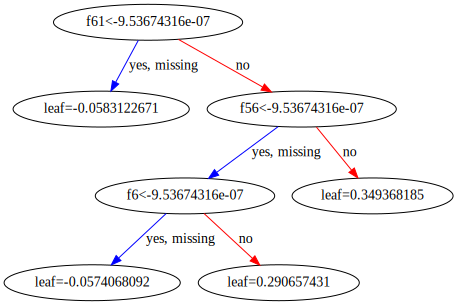

time: 52.3 ms


In [37]:
image = xgboost.to_graphviz(grid.best_estimator_.named_steps['xgbclassifier'])
image

The best multiclass classification model fitted to data and clusters produced by K-Prototypes resulted in the following scores:

*   ROC AUC: 0.92 (Excellent)
*   Balanced Accuracy: 0.73 (Substantial)
*   Cohen Kappa: 0.62 (Moderate - Substantial)

As a result of these metrics, I can only conclude that the clustering algorithm performs moderately.

#####**5.4.3. Explore Feature Importance**

In [38]:
processor = grid.best_estimator_.named_steps['columntransformer']
ohe_categories = processor.named_transformers_['onehotencoder'].categories_
new_ohe_features = [f'{col}__{val}' for col, vals in zip(col_cat, ohe_categories) for val in vals]
all_features = new_ohe_features + col_num
importance = pd.DataFrame(data=grid.best_estimator_.named_steps['xgbclassifier'].feature_importances_).rename(columns={0:'importance'})
importance['feature'] = all_features
importance = (importance.sort_values(by=['importance'], ascending=False)
             ).reset_index().drop(columns=['index'])
importance

,importance,feature
0,0.255761,Program Area__Drugs
1,0.218831,Program Area__Devices
2,0.202921,Classification__VAI
3,0.176418,Classification__NAI
4,0.070280,Country__United States
...,...,...
59,0.000000,Country__Lithuania
60,0.000000,Country__Macao
61,0.000000,Country__Malaysia
62,0.000000,Country__Mexico


time: 33.1 ms


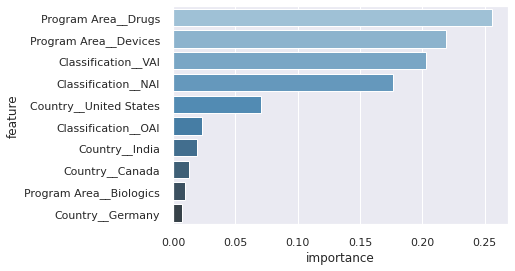

time: 352 ms


In [39]:
# Top 10 most important features
sns.barplot(x='importance', y='feature', data=importance.head(10), palette='Blues_d')

From XGBoost's feature importance attribute, we can see the following:

*   Feature *Program Area__Drugs* is most important feature and *Program Area__Devices* is second most important feature
*   Features *Classification__VAI* and *Classification__NAI* are third and fourth most important features for cluster prediction, and contribute more to cluster prediction than *Classification__OAI*, the sixth most important feature 
*   Feature *Country__United States*, *Country__India*, and *Country__Canada* are most important geographic features for cluster prediction



#**6. Conclusion**




Using UMAP, we can visually see that K-Prototype produces distinguishable clusters. However, the best multiclass classification model had a moderate (0.51-0.60) to substantial (0.61-0.70) score on the Cohen kappa metric for inter-rater agreement on clusters.

As such, we can conclude the following with moderate confidence:

*   Inspections classified OAI are often clustered with inspections for devices or drugs, in North America, and end with high count of citations
*   Inspections classified NAI are often clustered with inspections for devices, in North America, and end with lowest count of citations (none)